### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

Расмотрим пример на датасете из репозитория UCI

Описание данных - https://archive.ics.uci.edu/ml/datasets/ionosphere

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import  precision_score, roc_auc_score, accuracy_score, f1_score

from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score, classification_report, precision_recall_curve


class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


class RenameKey(BaseEstimator, TransformerMixin):
    def __init__(self, new_old_keys_dict):
        self.new_old_keys_dict = new_old_keys_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.rename(self.new_old_keys_dict, axis='columns')
        return X
    
    
class BinEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key, neg_class=None):
        self.key = key
        self.neg_class = neg_class

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.neg_class in X[self.key].unique():
            X.loc[(X[self.key] != self.neg_class), self.key ] = 1
            X.loc[(X[self.key] == self.neg_class), self.key ] = 0
            X[self.key] = pd.to_numeric(X[self.key])
            return X[[self.key]]

class RandomNegativeSamplingPU(BaseEstimator, TransformerMixin):
    def __init__(self, new_key_name='class_test', share_of_positive_classes=0.35):
        self.new_key_name = new_key_name
        self.share_of_positive_classes = share_of_positive_classes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        mod_data = X.copy()
        pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
        np.random.shuffle(pos_ind)
        pos_sample_len = int(np.ceil(self.share_of_positive_classes * len(pos_ind)))
        pos_sample = pos_ind[:pos_sample_len]
        
        mod_data[self.new_key_name] = -1
        mod_data.loc[pos_sample,self.new_key_name] = 1
        
        # перемешивает датасет
        mod_data = mod_data.sample(frac=1)
        # к отрицательному классу относим срез по немаркированому датасету
        # в количестве равном количеству положительных сигналов(строк)
        neg_sample = mod_data[mod_data[self.new_key_name]==-1][:pos_sample_len]
        # выделяем остальной немаркированный датасет для теста 
        sample_test = mod_data[mod_data[self.new_key_name]==-1][pos_sample_len:]
        # положительный датасет
        pos_sample = mod_data[mod_data[self.new_key_name]==1]
        # соединяем положительный и отрицательный датасеты с перемешиванием
        sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
        
        # X_sample_train = sample_train.iloc[:,:-2]
        # y_sample_train= sample_train.iloc[:,-2]
        # X_sample_test = sample_test.iloc[:,:-2]
        # y_sample_test = sample_test.iloc[:,-2]
        return sample_train, sample_test # X_sample_train, y_sample_train, X_sample_test, y_sample_test
        
        

def evaluate_results(y_test, y_predict, fstr=True):
    f1 = f1_score(y_test, y_predict)
    roc = roc_auc_score(y_test, y_predict)
    prc = precision_score(y_test, y_predict, average='binary')
    rec = recall_score(y_test, y_predict, average='binary')
    if fstr:
        return (f'Classification results:\n'
                f'F1_Score: \t{(f1*100.0):.3f}%\n'
                f'Roc_AUC: \t{(roc*100.0):.3f}%\n'
                f'Precision: \t{(prc*100.0):.3f}%\n'
                f'Recall: \t{(rec*100.0):.3f}%')
    else:
        return None, f1, roc, prc, rec
        

    
def get_metrics(y_test, probs, fstr=True):
    """
    Функция перехода от вероятностей к меткам классов.
    Для этого нужно подобрать порог - Best_Threshold={thresholds[ix]:.3f},
    после которого мы считаем,
    что объект можно отнести к классу 1 
    (если вероятность больше порога -
    размечаем объект как класс 1,
    если нет - класс 0)

    Args:
        y_test ([type]): [Истинные классы]
        probs ([type]): [Предсказанные вероятности принадлежности к классу]
        fstr (bool, optional): [флаг вывода]. Defaults to True.

    Returns:
        if fstr is True:
            [f'str']: [Выводиться f-string в виде: 
                        f'Best_Threshold={thresholds[ix]:.3f},\n'
                        f'F_Score={fscore[ix]:.3f},\n'
                        f'Precision={precision[ix]:.3f},\n'
                        f'Recall={recall[ix]:.3f},\n'
                        f'Roc_AUC={roc_auc_score(y_test, probs)}']
        else:
            [tuple]: [(
                       thresholds[ix]: float,
                       fscore[ix]: float,
                       precision[ix]: float,
                       recall[ix]: float,
                       roc_auc_score(y_test, probs): float
                       )]
    """
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    fscore = (2 * precision * recall) / (precision + recall)
    roc = roc_auc_score(y_test, probs)
    ix = np.argmax(fscore)
    if fstr:
        return(f'Best_Threshold:\t{thresholds[ix]:.3f},\n'
               f'F1_Score:\t{(fscore[ix]*100.0):.3f}%,\n'
               f'Roc_AUC:\t{(roc*100.0):.3f}%,\n'
               f'Precision:\t{(precision[ix]*100.0):.3f}%,\n'
               f'Recall: \t{(recall[ix]*100.0):.3f}%')
    else:
        return thresholds[ix], fscore[ix], roc, precision[ix], recall[ix]
    
def get_plot_bar(score, score_probs, df_score, score_name, kind='bar'):
    f_score_bar = pd.DataFrame({'Score':score,
                                'Score_probs':score_probs},
                               index=df_score.columns)
    ax = f_score_bar.plot(kind=kind, title=score_name)
    ax.legend(["Score", "Score_probs"])
    h,l = ax.get_legend_handles_labels()

In [2]:
with open("ionosphere_description.txt") as file:
    data_description = file.read()
print(data_description)

1. Title: Johns Hopkins University Ionosphere database

2. Source Information:
   -- Donor: Vince Sigillito (vgs@aplcen.apl.jhu.edu)
   -- Date: 1989
   -- Source: Space Physics Group
              Applied Physics Laboratory
              Johns Hopkins University
              Johns Hopkins Road
              Laurel, MD 20723 

3. Past Usage:
   -- Sigillito, V. G., Wing, S. P., Hutton, L. V., \& Baker, K. B. (1989).
      Classification of radar returns from the ionosphere using neural 
      networks. Johns Hopkins APL Technical Digest, 10, 262-266.

      They investigated using backprop and the perceptron training algorithm
      on this database.  Using the first 200 instances for training, which
      were carefully split almost 50% positive and 50% negative, they found
      that a "linear" perceptron attained 90.7%, a "non-linear" perceptron
      attained 92%, and backprop an average of over 96% accuracy on the 
      remaining 150 test instances, consisting of 123 "good" and 

In [3]:
data = pd.read_csv("ionosphere_data.txt", header=None)
data.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,0.34432,-0.69707,-0.51685,-0.97515,0.05499,-0.62237,0.33109,-1.00000,-0.13151,-0.45300,-0.18056,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,0.85443,0.00827,0.54591,0.00299,0.83775,-0.13644,0.75535,-0.08540,0.70887,-0.27502,0.43385,-0.12062,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       351 non-null    int64  
 1   1       351 non-null    int64  
 2   2       351 non-null    float64
 3   3       351 non-null    float64
 4   4       351 non-null    float64
 5   5       351 non-null    float64
 6   6       351 non-null    float64
 7   7       351 non-null    float64
 8   8       351 non-null    float64
 9   9       351 non-null    float64
 10  10      351 non-null    float64
 11  11      351 non-null    float64
 12  12      351 non-null    float64
 13  13      351 non-null    float64
 14  14      351 non-null    float64
 15  15      351 non-null    float64
 16  16      351 non-null    float64
 17  17      351 non-null    float64
 18  18      351 non-null    float64
 19  19      351 non-null    float64
 20  20      351 non-null    float64
 21  21      351 non-null    float64
 22  22

In [5]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
count,351.000000,351.0,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.891738,0.0,0.641342,0.044372,0.601068,0.115889,0.550095,0.119360,0.511848,0.181345,0.476183,0.155040,0.400801,0.093414,0.344159,0.071132,0.381949,-0.003617,0.359390,-0.024025,0.336695,0.008296,0.362475,-0.057406,0.396135,-0.071187,0.541641,-0.069538,0.378445,-0.027907,0.352514,-0.003794,0.349364,0.014480
std,0.311155,0.0,0.497708,0.441435,0.519862,0.460810,0.492654,0.520750,0.507066,0.483851,0.563496,0.494817,0.622186,0.494873,0.652828,0.458371,0.618020,0.496762,0.626267,0.519076,0.609828,0.518166,0.603767,0.527456,0.578451,0.508495,0.516205,0.550025,0.575886,0.507974,0.571483,0.513574,0.522663,0.468337
min,0.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,0.0,0.472135,-0.064735,0.412660,-0.024795,0.211310,-0.054840,0.087110,-0.048075,0.021120,-0.065265,0.000000,-0.073725,0.000000,-0.081705,0.000000,-0.225690,0.000000,-0.234670,0.000000,-0.243870,0.000000,-0.366885,0.000000,-0.332390,0.286435,-0.443165,0.000000,-0.236885,0.000000,-0.242595,0.000000,-0.165350
50%,1.000000,0.0,0.871110,0.016310,0.809200,0.022800,0.728730,0.014710,0.684210,0.018290,0.667980,0.028250,0.644070,0.030270,0.601940,0.000000,0.590910,0.000000,0.576190,0.000000,0.499090,0.000000,0.531760,0.000000,0.553890,-0.015050,0.708240,-0.017690,0.496640,0.000000,0.442770,0.000000,0.409560,0.000000
75%,1.000000,0.0,1.000000,0.194185,1.000000,0.334655,0.969240,0.445675,0.953240,0.534195,0.957895,0.482375,0.955505,0.374860,0.919330,0.308975,0.935705,0.195285,0.899265,0.134370,0.894865,0.188760,0.911235,0.164630,0.905240,0.156765,0.999945,0.153535,0.883465,0.154075,0.857620,0.200120,0.813765,0.171660
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Наш таргет
    "good" or "bad"
    g - good
    b - bad

In [6]:
data[34].unique()

array(['g', 'b'], dtype=object)

In [7]:
df_base = data.copy()
df_base.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,0.34432,-0.69707,-0.51685,-0.97515,0.05499,-0.62237,0.33109,-1.00000,-0.13151,-0.45300,-0.18056,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,0.85443,0.00827,0.54591,0.00299,0.83775,-0.13644,0.75535,-0.08540,0.70887,-0.27502,0.43385,-0.12062,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g


In [8]:
rename_feture = RenameKey({34: 'target'})

In [9]:
df_base = rename_feture.fit_transform(df_base)

In [10]:
target_bin = BinEncoder(key='target', neg_class='b')
target_bin.fit_transform(df_base).head(3)

,target
0,1
1,0
2,1


У нас есть 34 признака и 1 целевая переменная (бинарная) - нужно определить хороший сигнал или нет

In [11]:
print(df_base.shape)

(351, 35)


Всего 351 сигнал

Посмотрим на соотношение классов

In [12]:
df_base.iloc[:, -1].value_counts()

1    225
0    126
Name: target, dtype: int64

In [13]:
continuos_features = Pipeline([
                ('selector', ColumnSelector(key=[_ for _ in range(34)]))
            ])

feats = FeatureUnion([('continuos_features', continuos_features)])

feature_processing = Pipeline([('feats', feats)])

pipeline = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBClassifier(random_state = 21)),
])

In [14]:
X_data = df_base.iloc[:,:-1]
y_data = df_base.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=21)

In [15]:
pipeline.fit(X_train, y_train)

[00:04:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\programming\anaconda3\lib\site-packages\xgboost-1.4.1-py3.8-win-amd64.egg\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('continuos_features',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(key=[0,
                                                                                      1,
                                                                                      2,
                                                                                      3,
                                                                                      4,
                                                                                      5,
                                                                                      6,
                                                                                      7,
                                                                                      8,
                     

In [16]:
y_predict = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)
print(evaluate_results(y_test, y_predict))

D:\programming\anaconda3\lib\site-packages\xgboost-1.4.1-py3.8-win-amd64.egg\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Classification results:
F1_Score: 	93.023%
Roc_AUC: 	91.751%
Precision: 	95.238%
Recall: 	90.909%


In [17]:
thresholds, fscore, roc, precision, recall = evaluate_results(y_test, y_predict, fstr=False)
xgbc_score = {"XGBClassifier":pd.Series([thresholds,
                                         fscore,
                                         precision,
                                         recall,
                                         roc,],
                                        index=['Threshold',
                                               'F-Score',
                                               'ROC_AUC',
                                               'Precision',
                                               'Recall'
                                              ])}
df_score = pd.DataFrame(xgbc_score)

In [18]:
df_score

,XGBClassifier
Threshold,NaN
F-Score,0.930233
ROC_AUC,0.952381
Precision,0.909091
Recall,0.917508


In [19]:
print(get_metrics(y_test, y_pred_proba[:, 1]))

Best_Threshold:	0.148,
F1_Score:	94.382%,
Roc_AUC:	98.401%,
Precision:	93.333%,
Recall: 	95.455%


In [20]:
thresholds, fscore, roc, precision, recall = get_metrics(y_test, y_pred_proba[:, 1], fstr=False)
xgbc_score_prob = {"XGBClassifier_probs":pd.Series([thresholds,
                                                    fscore,
                                                    roc,
                                                    precision,
                                                    recall,
                                                   ],
                                                   index=['Threshold',
                                                          'F-Score',
                                                          'ROC_AUC',
                                                          'Precision',
                                                          'Recall'
                                                         ])}
df_score_prob = pd.DataFrame(xgbc_score_prob)
df_score_prob

,XGBClassifier_probs
Threshold,0.148428
F-Score,0.943820
ROC_AUC,0.984007
Precision,0.933333
Recall,0.954545


Разбиваем выборку на тренировочную и тестовую части и обучаем модель (в примере - градиентный бустинг)

### Теперь очередь за PU learning

Представим, что нам неизвестны негативы и часть позитивов

In [21]:
add_pu_class_45 = RandomNegativeSamplingPU(new_key_name='class_test', share_of_positive_classes=0.45)
add_pu_class_35 = RandomNegativeSamplingPU(new_key_name='class_test', share_of_positive_classes=0.35)
add_pu_class_25 = RandomNegativeSamplingPU(new_key_name='class_test', share_of_positive_classes=0.25)
add_pu_class_15 = RandomNegativeSamplingPU(new_key_name='class_test', share_of_positive_classes=0.15)
add_pu_class_5 = RandomNegativeSamplingPU(new_key_name='class_test', share_of_positive_classes=0.5)

sample_train_45, sample_test_45 = add_pu_class_45.fit_transform(df_base.copy())
sample_train_35, sample_test_35 = add_pu_class_35.fit_transform(df_base.copy())
sample_train_25, sample_test_25 = add_pu_class_25.fit_transform(df_base.copy())
sample_train_15, sample_test_15 = add_pu_class_15.fit_transform(df_base.copy())
sample_train_5, sample_test_5 = add_pu_class_5.fit_transform(df_base.copy())

In [22]:
pipeline_pu_45 = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBClassifier(random_state = 21)),
])

pipeline_pu_35 = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBClassifier(random_state = 21)),
])

pipeline_pu_25 = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBClassifier(random_state = 21)),
])

pipeline_pu_15 = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBClassifier(random_state = 21)),
])

pipeline_pu_5 = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBClassifier(random_state = 21)),
])

In [23]:
# X_sample_train = sample_train.iloc[:,:-2]
# y_sample_train= sample_train.iloc[:,-2]
pipeline_pu_45.fit(sample_train_45.iloc[:,:-2], sample_train_45.iloc[:,-2])
y_predict_pu_45 = pipeline_pu_45.predict(sample_test_45.iloc[:,:-2])
y_pred_proba_pu_45 = pipeline_pu_45.predict_proba(sample_test_45.iloc[:,:-2])

pipeline_pu_35.fit(sample_train_35.iloc[:,:-2], sample_train_35.iloc[:,-2])
y_predict_pu_35 = pipeline_pu_35.predict(sample_test_35.iloc[:,:-2])
y_pred_proba_pu_35 = pipeline_pu_35.predict_proba(sample_test_35.iloc[:,:-2])

pipeline_pu_25.fit(sample_train_25.iloc[:,:-2], sample_train_25.iloc[:,-2])
y_predict_pu_25 = pipeline_pu_25.predict(sample_test_25.iloc[:,:-2])
y_pred_proba_pu_25 = pipeline_pu_25.predict_proba(sample_test_25.iloc[:,:-2])

pipeline_pu_15.fit(sample_train_15.iloc[:,:-2], sample_train_15.iloc[:,-2])
y_predict_pu_15 = pipeline_pu_15.predict(sample_test_15.iloc[:,:-2])
y_pred_proba_pu_15 = pipeline_pu_15.predict_proba(sample_test_15.iloc[:,:-2])

pipeline_pu_5.fit(sample_train_5.iloc[:,:-2], sample_train_5.iloc[:,-2])
y_predict_pu_5 = pipeline_pu_5.predict(sample_test_5.iloc[:,:-2])
y_pred_proba_pu_5 = pipeline_pu_5.predict_proba(sample_test_5.iloc[:,:-2])

D:\programming\anaconda3\lib\site-packages\xgboost-1.4.1-py3.8-win-amd64.egg\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\programming\anaconda3\lib\site-packages\xgboost-1.4.1-py3.8-win-amd64.egg\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[00:04:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:04:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:04:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:04:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [24]:
print(f'{evaluate_results(sample_test_45.iloc[:,-2], y_predict_pu_45)}\n\n'
      f'{evaluate_results(sample_test_35.iloc[:,-2], y_predict_pu_35)}\n\n'
      f'{evaluate_results(sample_test_25.iloc[:,-2], y_predict_pu_25)}\n\n'
      f'{evaluate_results(sample_test_15.iloc[:,-2], y_predict_pu_15)}\n\n'
      f'{evaluate_results(sample_test_5.iloc[:,-2], y_predict_pu_5)}')


Classification results:
F1_Score: 	92.208%
Roc_AUC: 	91.972%
Precision: 	86.585%
Recall: 	98.611%

Classification results:
F1_Score: 	91.324%
Roc_AUC: 	89.650%
Precision: 	86.957%
Recall: 	96.154%

Classification results:
F1_Score: 	85.806%
Roc_AUC: 	78.753%
Precision: 	75.568%
Recall: 	99.254%

Classification results:
F1_Score: 	89.918%
Roc_AUC: 	84.643%
Precision: 	85.938%
Recall: 	94.286%

Classification results:
F1_Score: 	90.909%
Roc_AUC: 	92.143%
Precision: 	83.333%
Recall: 	100.000%


In [25]:
thresholds, fscore, roc, precision, recall = evaluate_results(sample_test_45.iloc[:,-2],
                                                              y_predict_pu_45,
                                                              fstr=False)
xgbc_score_pu_45 = {"XGBClassifier_rand_neg_sampl_45":
                    pd.Series([thresholds,
                               fscore,
                               roc,
                               precision,
                               recall,
                              ],
                              index=['Threshold',
                                     'F-Score',
                                     'ROC_AUC',
                                     'Precision',
                                     'Recall'
                                    ])}
df_score = df_score.join(pd.DataFrame(xgbc_score_pu_45))

thresholds, fscore, roc, precision, recall = evaluate_results(sample_test_35.iloc[:,-2],
                                                              y_predict_pu_35,
                                                              fstr=False)
xgbc_score_pu_35 = {"XGBClassifier_rand_neg_sampl_35":
                    pd.Series([thresholds,
                               fscore,
                               roc,
                               precision,
                               recall,
                              ],
                              index=['Threshold',
                                     'F-Score',
                                     'ROC_AUC',
                                     'Precision',
                                     'Recall'
                                    ])}
df_score = df_score.join(pd.DataFrame(xgbc_score_pu_35))

thresholds, fscore, roc, precision, recall = evaluate_results(sample_test_25.iloc[:,-2],
                                                              y_predict_pu_25,
                                                              fstr=False)
xgbc_score_pu_25 = {"XGBClassifier_rand_neg_sampl_25":
                    pd.Series([thresholds,
                               fscore,
                               roc,
                               precision,
                               recall,
                              ],
                              index=['Threshold',
                                     'F-Score',
                                     'ROC_AUC',
                                     'Precision',
                                     'Recall'
                                    ])}
df_score = df_score.join(pd.DataFrame(xgbc_score_pu_25))

thresholds, fscore, roc, precision, recall = evaluate_results(sample_test_15.iloc[:,-2],
                                                              y_predict_pu_15,
                                                              fstr=False)
xgbc_score_pu_15 = {"XGBClassifier_rand_neg_sampl_15":
                    pd.Series([thresholds,
                               fscore,
                               roc,
                               precision,
                               recall,
                              ],
                              index=['Threshold',
                                     'F-Score',
                                     'ROC_AUC',
                                     'Precision',
                                     'Recall'
                                    ])}
df_score = df_score.join(pd.DataFrame(xgbc_score_pu_15))

thresholds, fscore, roc, precision, recall = evaluate_results(sample_test_5.iloc[:,-2],
                                                              y_predict_pu_5,
                                                              fstr=False)
xgbc_score_pu_5 = {"XGBClassifier_rand_neg_sampl_5":
                    pd.Series([thresholds,
                               fscore,
                               roc,
                               precision,
                               recall,
                              ],
                              index=['Threshold',
                                     'F-Score',
                                     'ROC_AUC',
                                     'Precision',
                                     'Recall'
                                    ])}
df_score = df_score.join(pd.DataFrame(xgbc_score_pu_5))

df_score

,XGBClassifier,XGBClassifier_rand_neg_sampl_45,XGBClassifier_rand_neg_sampl_35,XGBClassifier_rand_neg_sampl_25,XGBClassifier_rand_neg_sampl_15,XGBClassifier_rand_neg_sampl_5
Threshold,NaN,NaN,NaN,NaN,NaN,NaN
F-Score,0.930233,0.922078,0.913242,0.858065,0.899183,0.909091
ROC_AUC,0.952381,0.919722,0.896500,0.787531,0.846429,0.921429
Precision,0.909091,0.865854,0.869565,0.755682,0.859375,0.833333
Recall,0.917508,0.986111,0.961538,0.992537,0.942857,1.000000


In [26]:
print(f'{get_metrics(sample_test_45.iloc[:,-2], y_pred_proba_pu_45[:, 1])}\n\n'
      f'{get_metrics(sample_test_35.iloc[:,-2], y_pred_proba_pu_35[:, 1])}\n\n'
      f'{get_metrics(sample_test_25.iloc[:,-2], y_pred_proba_pu_25[:, 1])}\n\n'
      f'{get_metrics(sample_test_15.iloc[:,-2], y_pred_proba_pu_15[:, 1])}\n\n'
      f'{get_metrics(sample_test_5.iloc[:,-2], y_pred_proba_pu_5[:, 1])}')

Best_Threshold:	0.826,
F1_Score:	95.890%,
Roc_AUC:	97.944%,
Precision:	94.595%,
Recall: 	97.222%

Best_Threshold:	0.886,
F1_Score:	93.137%,
Roc_AUC:	95.754%,
Precision:	95.000%,
Recall: 	91.346%

Best_Threshold:	0.946,
F1_Score:	92.473%,
Roc_AUC:	94.508%,
Precision:	88.966%,
Recall: 	96.269%

Best_Threshold:	0.735,
F1_Score:	91.954%,
Roc_AUC:	93.952%,
Precision:	92.486%,
Recall: 	91.429%

Best_Threshold:	0.933,
F1_Score:	94.444%,
Roc_AUC:	98.831%,
Precision:	96.226%,
Recall: 	92.727%


In [27]:
thresholds, roc, fscore, precision, recall = get_metrics(sample_test_45.iloc[:,-2],
                                                         y_pred_proba_pu_45[:, 1],
                                                         fstr=False)
xgbc_score_prob_45 = {"XGBClassifier_probs_rand_neg_sampl_45":
                      pd.Series([thresholds,
                                 fscore,
                                 roc,
                                 precision,
                                 recall,
                                ],
                                index=['Threshold',
                                       'F-Score',
                                       'ROC_AUC',
                                       'Precision',
                                       'Recall'
                                      ])}
df_score_prob = df_score_prob.join(pd.DataFrame(xgbc_score_prob_45))

thresholds, roc, fscore, precision, recall = get_metrics(sample_test_35.iloc[:,-2],
                                                         y_pred_proba_pu_35[:, 1],
                                                         fstr=False)
xgbc_score_prob_35 = {"XGBClassifier_probs_rand_neg_sampl_35":
                      pd.Series([thresholds,
                                 fscore,
                                 roc,
                                 precision,
                                 recall,
                                ],
                                index=['Threshold',
                                       'F-Score',
                                       'ROC_AUC',
                                       'Precision',
                                       'Recall'
                                      ])}
df_score_prob = df_score_prob.join(pd.DataFrame(xgbc_score_prob_35))

thresholds, roc, fscore, precision, recall = get_metrics(sample_test_25.iloc[:,-2],
                                                         y_pred_proba_pu_25[:, 1],
                                                         fstr=False)
xgbc_score_prob_25 = {"XGBClassifier_probs_rand_neg_sampl_25":
                      pd.Series([thresholds,
                                 fscore,
                                 roc,
                                 precision,
                                 recall,
                                ],
                                index=['Threshold',
                                       'F-Score',
                                       'ROC_AUC',
                                       'Precision',
                                       'Recall'
                                      ])}
df_score_prob = df_score_prob.join(pd.DataFrame(xgbc_score_prob_25))

thresholds, roc, fscore, precision, recall = get_metrics(sample_test_15.iloc[:,-2],
                                                         y_pred_proba_pu_15[:, 1],
                                                         fstr=False)
xgbc_score_prob_15 = {"XGBClassifier_probs_rand_neg_sampl_15":
                      pd.Series([thresholds,
                                 fscore,
                                 roc,
                                 precision,
                                 recall,
                                ],
                                index=['Threshold',
                                       'F-Score',
                                       'ROC_AUC',
                                       'Precision',
                                       'Recall'
                                      ])}
df_score_prob = df_score_prob.join(pd.DataFrame(xgbc_score_prob_15))

thresholds, roc, fscore, precision, recall = get_metrics(sample_test_5.iloc[:,-2],
                                                         y_pred_proba_pu_5[:, 1],
                                                         fstr=False)
xgbc_score_prob_5 = {"XGBClassifier_probs_rand_neg_sampl_5":
                      pd.Series([thresholds,
                                 fscore,
                                 roc,
                                 precision,
                                 recall,
                                ],
                                index=['Threshold',
                                       'F-Score',
                                       'ROC_AUC',
                                       'Precision',
                                       'Recall'
                                      ])}
df_score_prob = df_score_prob.join(pd.DataFrame(xgbc_score_prob_5))

df_score_prob

,XGBClassifier_probs,XGBClassifier_probs_rand_neg_sampl_45,XGBClassifier_probs_rand_neg_sampl_35,XGBClassifier_probs_rand_neg_sampl_25,XGBClassifier_probs_rand_neg_sampl_15,XGBClassifier_probs_rand_neg_sampl_5
Threshold,0.148428,0.825726,0.886296,0.946048,0.734873,0.933204
F-Score,0.943820,0.979444,0.957541,0.945080,0.939524,0.988312
ROC_AUC,0.984007,0.958904,0.931373,0.924731,0.919540,0.944444
Precision,0.933333,0.945946,0.950000,0.889655,0.924855,0.962264
Recall,0.954545,0.972222,0.913462,0.962687,0.914286,0.927273


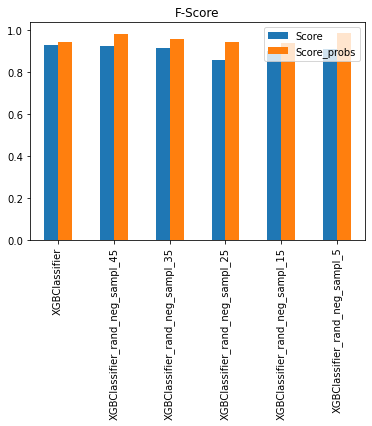

In [28]:
get_plot_bar(df_score.loc['F-Score',:].values, df_score_prob.loc['F-Score',:].values, df_score, 'F-Score')

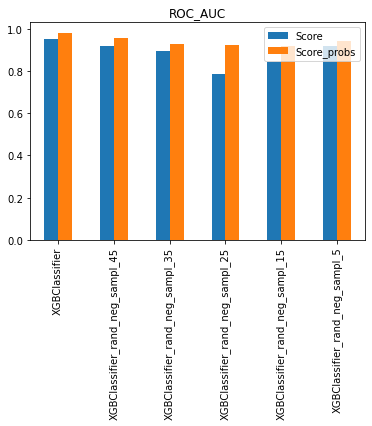

In [29]:
get_plot_bar(df_score.loc['ROC_AUC',:].values, df_score_prob.loc['ROC_AUC',:].values, df_score, 'ROC_AUC')

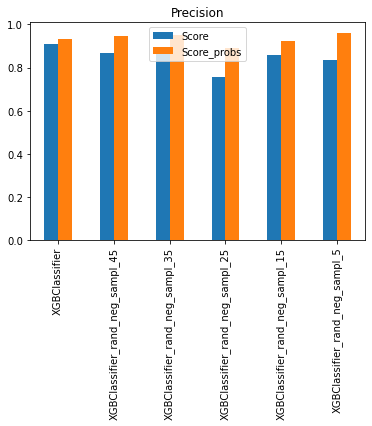

In [30]:
get_plot_bar(df_score.loc['Precision',:].values, df_score_prob.loc['Precision',:].values, df_score, 'Precision')

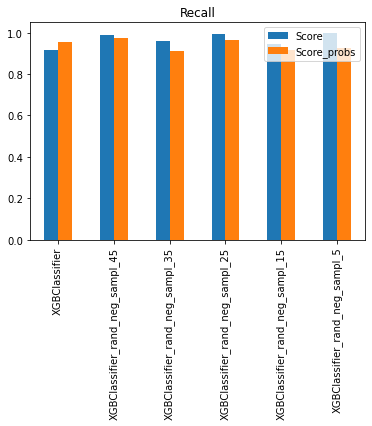

In [31]:
get_plot_bar(df_score.loc['Recall',:].values, df_score_prob.loc['Recall',:].values, df_score, 'Recall')

Использование predict_proba дает лучшие результаты.
На исследуемых данных четкой зависимости от доли выборки для положительного класса не наблюдается.

In [32]:
df_score.T.describe()

,Threshold,F-Score,ROC_AUC,Precision,Recall
count,0.0,6.000000,6.000000,6.000000,6.000000
mean,NaN,0.905315,0.887332,0.848817,0.966759
std,NaN,0.025492,0.060267,0.051728,0.032150
min,NaN,0.858065,0.787531,0.755682,0.917508
25%,NaN,0.901660,0.858946,0.839844,0.947527
50%,NaN,0.911166,0.908111,0.862614,0.973825
75%,NaN,0.919869,0.921002,0.868637,0.990931
max,NaN,0.930233,0.952381,0.909091,1.000000


In [33]:
df_score_prob.T.describe()

,Threshold,F-Score,ROC_AUC,Precision,Recall
count,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.745762,0.958954,0.943833,0.934342,0.940746
std,0.302761,0.020410,0.024297,0.025485,0.025646
min,0.148428,0.939524,0.919540,0.889655,0.913462
25%,0.757586,0.944135,0.926392,0.926975,0.917532
50%,0.856011,0.951311,0.937908,0.939640,0.940909
75%,0.921477,0.973969,0.955289,0.948986,0.960651
max,0.946048,0.988312,0.984007,0.962264,0.972222


<b>Бонусный вопрос:</b>

Как вы думаете, какой из методов на практике является более предпочтительным: random negative sampling или 2-step approach?

Ваш ответ здесь:

### random negative sampling  - для быстрого расчета
### 2-step approach - для более точного